# Intro to image classification with PyTorch

**Make sure you look at [`Image classification`](Image_classification.ipynb) before coming here.**

We'll use `Pytorch` on its own in this notebook. See the accompanying notebook, [`Image classification with skorch`](Image_classification_with_skorch.ipynb) to see some helper libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## The fossil dataset

Let's generate a workflow to classify images using a CNN.
We'll make use of a collection of functions in `utils.py` to help process the images found in the `data/fossils` folder.

In [2]:
import numpy as np

ds = np.DataSource('../data/')

X = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_X.npy', mode='rb'))
y = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_y.npy', mode='rb'))

In [294]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [295]:
X_train.shape

(498, 1024)

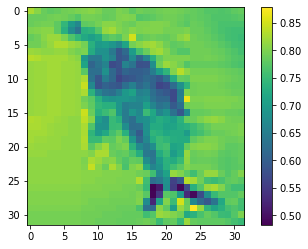

In [296]:
plt.imshow(X_train[1].reshape(32,32))
plt.colorbar()

## `sklearn.neural_network`

We'll first train a fully connected network. This requires the images to be 1D vectors, like the ones we have, but this means we'll lose some of the 2D spatial properties... Until we use a convolutional neural network!

See the notebook [Intro to image classification](Intro_to_image_classification.ipynb).

In [305]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = MLPClassifier(hidden_layer_sizes=[100, 24], max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

   ammonites       0.69      0.64      0.67        28
        fish       0.75      0.88      0.81        34
  trilobites       0.55      0.46      0.50        26

    accuracy                           0.68        88
   macro avg       0.66      0.66      0.66        88
weighted avg       0.67      0.68      0.67        88



We'll start by replicating this in `pytorch`.

## The `pytorch` approach

We'll need to encode the target variable so that the classes are represented by integers. We can use scikit-learn's `LabelEncoder` for that:

In [306]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(np.append(y_train, y_val))

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

In [307]:
y_val

array([2, 1, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       0, 1, 1, 0, 0, 2, 1, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       2, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0,
       2, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2])

Now we can make a `Sequential` model and train it.

In [308]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Define the architecture of the network

In [309]:
class FossilNet(torch.nn.Module):
    def __init__(self):
        super(FossilNet, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 24)
        self.act2 = nn.ReLU()
        self.out = nn.Linear(24, 3)
        # nb Criterion includes softmax.
        
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = self.act1(z1)
        z2 = self.fc2(a1)
        a2 = self.act2(z2)
        z3 = self.out(a2)
        return z3

model = FossilNet()

In [310]:
model

FossilNet(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=24, bias=True)
  (act2): ReLU()
  (out): Linear(in_features=24, out_features=3, bias=True)
)

Now define the loss function, which Torch calls the 'criterion', and the optimizer:

In [311]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.003,
                            weight_decay=0.01,  # L2 regularization.
                            momentum=0.9,
                           )

Get the data ready for Torch:

In [312]:
X_train_ = torch.Tensor(X_train).to(device)
y_train_ = torch.Tensor(y_train).type(torch.LongTensor).to(device)
X_val_ = torch.Tensor(X_val).to(device)
y_val_ = torch.Tensor(y_val).type(torch.LongTensor).to(device)

Now we can write the training loop:

In [313]:
epochs = 500
vals, trains = [], []
idx = np.arange(0, y_train.size)

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_train_ = X_train_[idx]
    y_train_ = y_train_[idx]
    
    # Train.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_)  # No batches.
    loss = criterion(y_pred, y_train_)  
    loss.backward()
    optimizer.step()
    
    # Capture training loss.
    print(f"Epoch {epoch}/{epochs}: train loss: {loss.item():.3f}")
    trains.append(loss.item())

    # Capture validation loss.
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_)
        loss = criterion(y_pred, y_val_)    
        vals.append(loss.item())

Epoch 0/500: train loss: 1.099
Epoch 1/500: train loss: 1.099
Epoch 2/500: train loss: 1.098
Epoch 3/500: train loss: 1.098
Epoch 4/500: train loss: 1.098
Epoch 5/500: train loss: 1.097
Epoch 6/500: train loss: 1.097
Epoch 7/500: train loss: 1.096
Epoch 8/500: train loss: 1.095
Epoch 9/500: train loss: 1.095
Epoch 10/500: train loss: 1.094
Epoch 11/500: train loss: 1.094
Epoch 12/500: train loss: 1.093
Epoch 13/500: train loss: 1.093
Epoch 14/500: train loss: 1.092
Epoch 15/500: train loss: 1.092
Epoch 16/500: train loss: 1.092
Epoch 17/500: train loss: 1.091
Epoch 18/500: train loss: 1.091
Epoch 19/500: train loss: 1.091
Epoch 20/500: train loss: 1.091
Epoch 21/500: train loss: 1.090
Epoch 22/500: train loss: 1.090
Epoch 23/500: train loss: 1.090
Epoch 24/500: train loss: 1.090
Epoch 25/500: train loss: 1.089
Epoch 26/500: train loss: 1.089
Epoch 27/500: train loss: 1.089
Epoch 28/500: train loss: 1.089
Epoch 29/500: train loss: 1.088
Epoch 30/500: train loss: 1.088
Epoch 31/500: trai

Epoch 266/500: train loss: 0.975
Epoch 267/500: train loss: 0.974
Epoch 268/500: train loss: 0.974
Epoch 269/500: train loss: 0.973
Epoch 270/500: train loss: 0.972
Epoch 271/500: train loss: 0.972
Epoch 272/500: train loss: 0.971
Epoch 273/500: train loss: 0.970
Epoch 274/500: train loss: 0.970
Epoch 275/500: train loss: 0.969
Epoch 276/500: train loss: 0.968
Epoch 277/500: train loss: 0.968
Epoch 278/500: train loss: 0.967
Epoch 279/500: train loss: 0.966
Epoch 280/500: train loss: 0.966
Epoch 281/500: train loss: 0.965
Epoch 282/500: train loss: 0.964
Epoch 283/500: train loss: 0.964
Epoch 284/500: train loss: 0.963
Epoch 285/500: train loss: 0.962
Epoch 286/500: train loss: 0.962
Epoch 287/500: train loss: 0.961
Epoch 288/500: train loss: 0.961
Epoch 289/500: train loss: 0.960
Epoch 290/500: train loss: 0.959
Epoch 291/500: train loss: 0.959
Epoch 292/500: train loss: 0.958
Epoch 293/500: train loss: 0.957
Epoch 294/500: train loss: 0.957
Epoch 295/500: train loss: 0.956
Epoch 296/

And inspect the history:

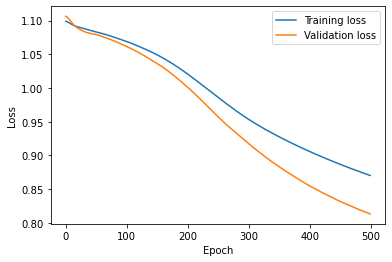

In [314]:
plt.plot(trains, label='Training loss')
plt.plot(vals, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

[Validation loss lower than training loss?](https://twitter.com/aureliengeron/status/1110839223878184960)

This can happen for a few reasons:

- The training loss is measured during the epoch, while validation loss is measured after it. So the model used in validation is a bit better.
- The training loss includes the regularization penalty, whereas the validation loss does not.
- The validation data might be more predictable than the training data.

## Evaluation

In [315]:
y_out = model(X_val_).detach().numpy()

But these are not probabilities:

In [316]:
np.sum(y_out, axis=-1)

array([-0.07065892,  0.03627357,  0.08944532,  0.045237  ,  0.0072408 ,
        0.15102342,  0.04205596,  0.06244233, -0.02383322, -0.00585485,
        0.02435952, -0.01147437,  0.00213015,  0.05594885,  0.05145094,
        0.02258205,  0.01931477,  0.1013685 ,  0.07200128,  0.03295314,
       -0.06037301,  0.03572485,  0.08864689,  0.0197705 ,  0.0115009 ,
        0.15362376, -0.05130589,  0.06115377, -0.03904092, -0.12965655,
        0.02777253,  0.01112592,  0.04457653,  0.09029639,  0.09551246,
        0.04842305,  0.10790105,  0.01681995, -0.06640597,  0.10554461,
       -0.00545703, -0.0126131 ,  0.0659862 , -0.05535775, -0.04624808,
       -0.06836981, -0.02278233, -0.05882329,  0.04427189,  0.00158019,
       -0.08483183,  0.12580018,  0.07366943,  0.08622947,  0.09967107,
        0.04769707, -0.06838292, -0.03459299,  0.12439765, -0.005932  ,
        0.02589452,  0.02519701, -0.08759767, -0.13617086,  0.04637742,
        0.07953514,  0.04768291,  0.05463529,  0.02409649,  0.18

In [317]:
from scipy.special import softmax

y_prob = softmax(y_out, axis=-1)

np.sum(y_prob, axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 0.99999994, 1.        ,
       0.9999999 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.0000001 , 1.0000001 ,
       1.        , 0.9999999 , 0.9999999 , 0.9999999 , 1.0000001 ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.9999999 , 1.        , 1.0000001 , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.0000001 ,
       1.        , 1.        , 0.99999994, 0.9999999 , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.0000001 , 1.0000001 , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 0.99999994, 1.        , 1.0000001 , 1.     

That's better!

Now we can find the argmax for each record:

In [318]:
y_pred = np.argmax(y_prob, axis=-1)

In [319]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.50      0.65        28
           1       0.67      0.82      0.74        34
           2       0.48      0.58      0.53        26

    accuracy                           0.65        88
   macro avg       0.69      0.63      0.64        88
weighted avg       0.70      0.65      0.65        88



## Class probability

The network can emit probabilities. Each instance's vector contains the probability of each class. The argmax of this gives the predicted class.

In our poor result, the classes are almost equally likely.

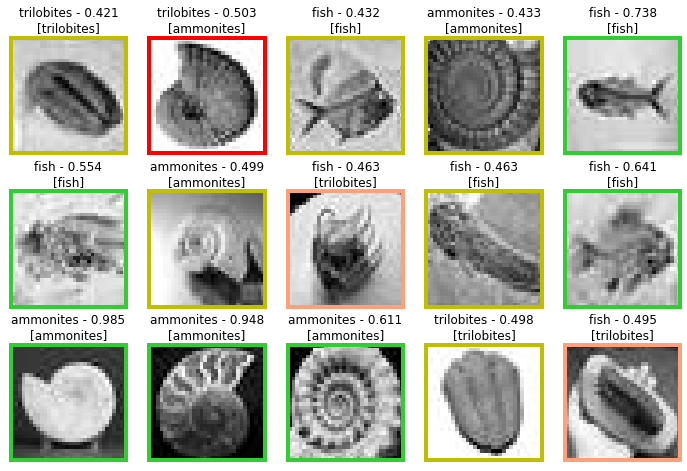

In [320]:
import utils

utils.visualize(X_val, y_val, y_prob,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_)
plt.show()

## Convolution

Convolutional networks replace the weights with kernels, and the multiplication step with convolution.

Let's see what convolution can do to an image.

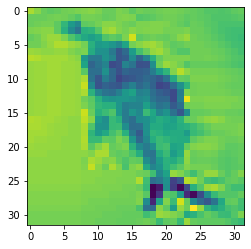

In [265]:
plt.imshow(img)

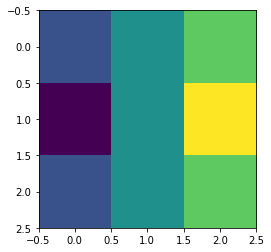

In [266]:
kernel = np.array([[-1, 0, 1],   # Sobel edge detector
                   [-2, 0, 2],
                   [-1, 0, 1]])

plt.imshow(kernel)

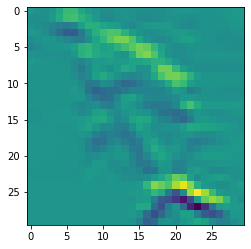

In [267]:
from scipy.signal import convolve2d

attr = convolve2d(img, kernel.T, mode='valid')

plt.imshow(attr)

Here's a nice resource on ConvNets: https://cs231n.github.io/convolutional-networks/

## A convolutional neural network

In [322]:
class FossilCNN(torch.nn.Module):
    def __init__(self):
        super(FossilCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 24, (3, 3), padding=0)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(24)

        self.conv2 = nn.Conv2d(24, 8, (3, 3), padding=0)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(8)

        self.fc = nn.Linear(8 * 28 * 28, 3)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

model = FossilCNN()

In [323]:
model

FossilCNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=6272, out_features=3, bias=True)
)

In [324]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.003,
                            weight_decay=0.01,  # L2 regularization.
                            momentum=0.9,
                           )

In [325]:
X_train_ = torch.Tensor(X_train.reshape(-1, 1, 32, 32)).to(device)
y_train_ = torch.Tensor(y_train).type(torch.LongTensor).to(device)
X_val_ = torch.Tensor(X_val.reshape(-1, 1, 32, 32)).to(device)
y_val_ = torch.Tensor(y_val).type(torch.LongTensor).to(device)

In [326]:
epochs = 100
vals, trains = [], []
idx = np.arange(0, y_train.size)

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_train_ = X_train_[idx]
    y_train_ = y_train_[idx]
    
    # Train.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_)  # No batches.
    loss = criterion(y_pred, y_train_)  
    loss.backward()
    optimizer.step()
    
    # Capture training loss.
    print(f"Epoch {epoch}/{epochs}: train loss: {loss.item():.3f}")
    trains.append(loss.item())

    # Capture validation loss.
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_)
        loss = criterion(y_pred, y_val_)    
        vals.append(loss.item())

Epoch 0/100: train loss: 1.191
Epoch 1/100: train loss: 0.987
Epoch 2/100: train loss: 0.870
Epoch 3/100: train loss: 0.810
Epoch 4/100: train loss: 0.771
Epoch 5/100: train loss: 0.755
Epoch 6/100: train loss: 0.713
Epoch 7/100: train loss: 0.674
Epoch 8/100: train loss: 0.636
Epoch 9/100: train loss: 0.592
Epoch 10/100: train loss: 0.565
Epoch 11/100: train loss: 0.545
Epoch 12/100: train loss: 0.527
Epoch 13/100: train loss: 0.503
Epoch 14/100: train loss: 0.467
Epoch 15/100: train loss: 0.448
Epoch 16/100: train loss: 0.422
Epoch 17/100: train loss: 0.402
Epoch 18/100: train loss: 0.373
Epoch 19/100: train loss: 0.359
Epoch 20/100: train loss: 0.340
Epoch 21/100: train loss: 0.331
Epoch 22/100: train loss: 0.315
Epoch 23/100: train loss: 0.303
Epoch 24/100: train loss: 0.288
Epoch 25/100: train loss: 0.275
Epoch 26/100: train loss: 0.262
Epoch 27/100: train loss: 0.251
Epoch 28/100: train loss: 0.241
Epoch 29/100: train loss: 0.230
Epoch 30/100: train loss: 0.222
Epoch 31/100: trai

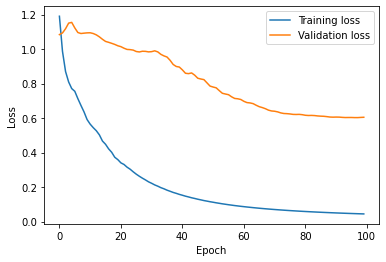

In [327]:
plt.plot(trains, label='Training loss')
plt.plot(vals, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluation

Can you evaluate this model? Write a function to handle everything. You will need to:

- Compute the model output to make `y_out` (don't forget to detach the tensor).
- Use the `softmax` function to turn the output into probabilities, `y_pred`.
- Get the argmax of the probabilities to make `y_pred`.
- Return `y_prob` and `y_pred`.
- Print a classification report.

In [328]:
def predict(X, model):
    X = torch.Tensor(X.reshape(-1, 1, 32, 32)).to(device)
    """Use `model` to predict on `X`."""
    # YOUR CODE HERE
    
    
    return y_prob, y_pred

In [373]:
def predict(X, model):
    X = torch.Tensor(X.reshape(-1, 1, 32, 32)).to(device)
    y_out = model(X).detach().numpy()
    y_prob = softmax(y_out, axis=-1)
    y_pred = np.argmax(y_prob, axis=-1)
    return y_prob, y_pred
    
y_prob, y_pred = predict(X_val_, model)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.79      0.79      0.79        34
           2       0.64      0.69      0.67        26

    accuracy                           0.74        88
   macro avg       0.74      0.73      0.73        88
weighted avg       0.74      0.74      0.74        88



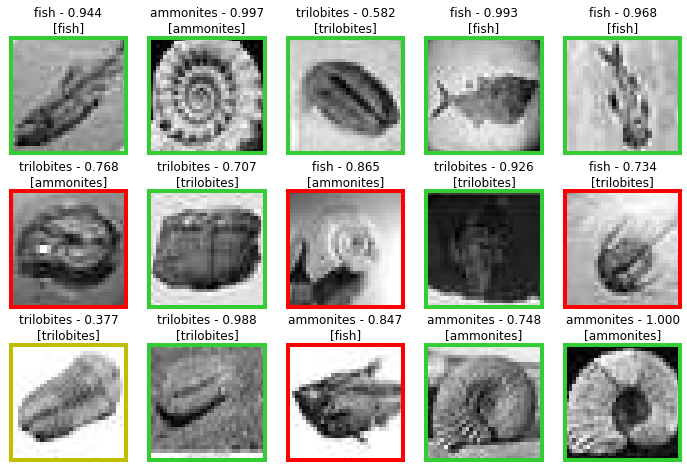

In [374]:
utils.visualize(X_val, y_val, y_prob,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_
               )

## The kernels

In [375]:
w1 = model.conv1.weight.detach().numpy()
w1.shape

(24, 1, 3, 3)

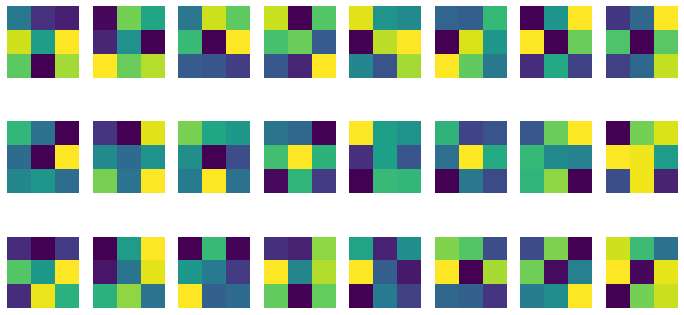

In [376]:
fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(12, 6))
for w, ax in zip(w1, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

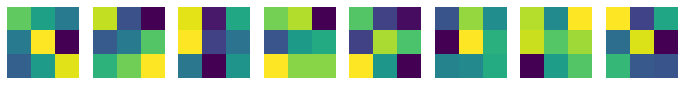

In [377]:
w2 = model.conv2.weight.detach().numpy()

fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(12, 3))
for w, ax in zip(w2, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

## Model persistence and future inference

The easiest way to save a model is with `torch.save`, but `state_dict` is just an `OrderedDict` so you can do anything you want with it.

In [349]:
torch.save(model.state_dict(), './fossilnet.pt')

Later, you or someone else can load it. Note that you need to instantiate the model first; the state dictionary does not contain the architecture.

In [378]:
model = FossilCNN()
model.load_state_dict(torch.load('./fossilnet.pt'))
model.eval()

FossilCNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=6272, out_features=3, bias=True)
)

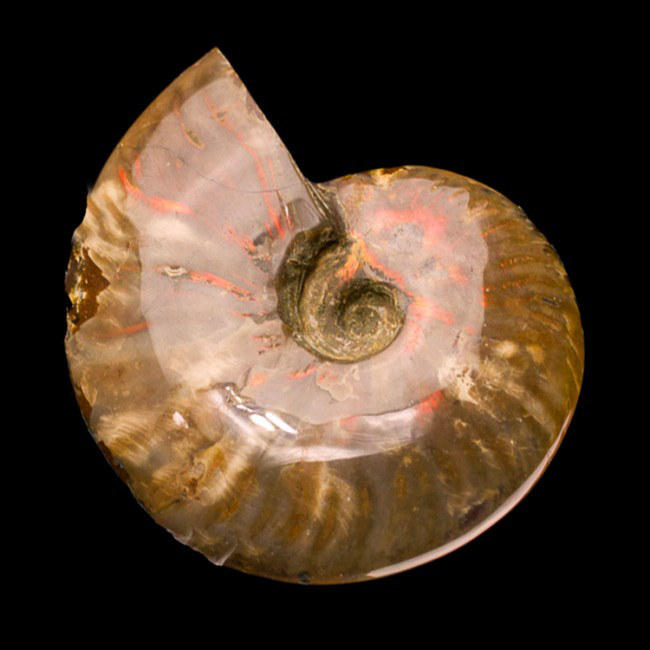

In [394]:
from PIL import Image
import io
import requests

url = "https://www.treasuremountainmining.com/image/cache/data/2017/08-17/Adam30/EB0817AMMOR4-650x650.jpg"
r = requests.get(url)
img = Image.open(io.BytesIO(r.content))
img

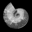

In [395]:
img = img.convert(mode='L')
img.thumbnail(size=(32, 32))
img

In [396]:
ima = np.asarray(img) / 255
ima.shape

(32, 32)

In [397]:
x = torch.Tensor(ima.reshape(-1, 1, 32, 32)).to(device)

y_prob, y_pred = predict(x, model)

print(f"Class {encoder.classes_[y_pred].item().upper():} with p={np.max(y_prob):.3f}")

Class AMMONITES with p=1.000


---

&copy; 2020 Agile Scientific